# SbD4Nano WP2 assertions

RDFy the correlational assertion literature review for the case: S-doped SiO2@TiO2 addition to paint formulation

## Background

Adding TiO2 NPs to paint formulation is common for the photocatalysis of  the degradation of pollutants in paint. Moreover, it is known to enhance optical properties and to scatter UV, preventing discoloration The Sulphur doping is known to improve TiO2 photocatalytic activity (https://www.sciencedirect.com/science/article/pii/S0920586110008412). The external amorphous silica layer (SiO2) is hypothesized to reduce toxicity and dustiness, sort of 'retaining' the individual particles. Since TiO2 is considered by the EU to be carcinogenic, it is crucial to try to reduce its ability to 'escape' from the paint and become toxic.

The literature search focused on:
1. Stability of the nanocomposite in possible exposure scenarios (sol-gel synthesis, weathering of the paints)
2. TiO2 safety/toxicity as determined by its properties (rutile or anatase, concentration, etc.)
3. Assertions involving structure and funtion (photocatalytic potential)
4. S-doping specific knowledge

## What's in this notebook

This notebook:
1.  Uses the Google API client library to retrieve the [spreadsheet](https://docs.google.com/spreadsheets/d/13dqwura-jSnGMVBSO7pVXfRgbPegGC7QNoSLNAFls3A/) with the curated data
2.  Describes and characterizes the curated data set. This step includes the programatic retrieval of the license type for each used publication
3.  Guides through the process of RDF-ying using `rdflib`
4.  Performs some QC SPARQL queries on the generated graphs

## Status
This is a work in progress. Following iterations will address the lack of expressivity of the model and include the missing annotated experimental conditions (the _context_ surrounding the described effects or co-ocurrences of physicochemical properties and biological endpoints or events).

## Imports and configuration

In [1]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os.path
import pickle
import pandas as pd
import yaml
from rdflib import Graph, URIRef, Literal, BNode, Namespace
from rdflib.namespace import DC, RDFS, FOAF, DCTERMS, VOID, RDF, XSD, OWL
import requests

Each page in the spreadsheet is retrieved according to the range defined in the `config.yaml` config file.

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f.read())
    SCOPES = config['SCOPES']
    SPREADSHEET_ID = config['SPREADSHEET']
    RANGE_ASSERTIONS = config['ASSERTIONS']
    RANGE_MATERIALS = config['MATERIALS']
    RANGE_ASSAYS = config['ASSAYS']
    RANGE_NODE_BREAKDOWN = config['NODE_BREAKDOWN']
    RANGE_MEASUREMENT_GROUPS = config['MEASUREMENT_GROUPS']
    RANGE_QUOTES = config['QUOTES']
    EMAIL = config['EMAIL']

## Retrieve data
The following function is used over all ranges in [`config.yaml`]('config.yaml') to retrieve the following data as pandas data frames: 
- `assertions`: the _nodes_ of causal relationships supported by the `quotes` and all other supporting data
- `quotes`: the quotes stating causal relationships, together with their source and the `cito:citesAsReference` statement, if applicable
- `node_breakdown`: TBD
- `assays`: characterization of the assays realized on `materials` to observe the results that led to the formulation of `assertions`
- `measurement_groups`: characterization of the biological systems tested in the `assays`
- `materials`: characterization of the materials used in the `assays` on the `measurement_groups`

TBD: schema of the relations between tables

In [3]:
def get_google_sheet(sheet, spreadsheet_id=SPREADSHEET_ID):
    creds = None
    range_name = globals()['RANGE_{}'.format(sheet)]
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server()
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    service = build('sheets', 'v4', credentials=creds)
    gsheet = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
    values = gsheet.get('values', [])
    if not values:
        print('No data found.')
    else:
        df = pd.DataFrame(values, columns=values[0]).drop(axis=1,index=0)
        return df


In [4]:
quotes = get_google_sheet('QUOTES')
assertions = get_google_sheet('ASSERTIONS')
materials = get_google_sheet('MATERIALS')
assays = get_google_sheet('ASSAYS')
measurement_groups = get_google_sheet('MEASUREMENT_GROUPS')
node_breakdown = get_google_sheet('NODE_BREAKDOWN')

### Quotes
These are the passages of text from the research articles that best encapsulate the observed relations.

In [5]:
quotes.describe()

,id,quote,doi,cito:containsAssertionFrom,review,comment
count,171,170,170,170,170,22
unique,171,145,49,45,3,19
top,Q1,,https://doi.org/10.3390/nano9071041,,no,assay-syn
freq,1,26,22,121,135,3


In [6]:
quotes.sample(5)

,id,quote,doi,cito:containsAssertionFrom,review,comment
1,Q1,due to the different atomic mass of titanium a...,https://doi.org/10.1016/j.apcata.2021.118179,,no,"different atomic mass, same composition (SiO2 ..."
136,Q136,TiO2 sol–gel was prepared by hydrolysis of tit...,https://doi.org/10.1016/S0920-5861(02)00225-0,,no,assay-syn
160,Q170,"Interestingly, the CTS-1050, even though with ...",https://doi.org/10.1016/j.ceramint.2021.12.096,,no,None
158,Q168,The analysis of the LC3BII protein allows us t...,https://doi.org/10.3390/nano9071041,,no,None
52,Q52,,https://doi.org/10.1039/C9EN00951E,,no,None


Some sample quotes:

In [7]:
print('-', '\n- '.join(list(quotes['quote'].sample(2))))

- 
- TiO2 sol–gel was prepared by hydrolysis of titanium isopropoxide (Aldrich) in abundant water acidulated with nitric acid (Merck, PA), following by peptisation at 80 °C for 16 h [19]. This procedure yields particles of 5–10 nm diameters, aggregated in 100 nm clusters.


### Assertions
These are the manually curated "triples" that capture the stated relations.

In [8]:
assertions.describe()

,Ref_quote,quote,doi,REVIEW?,s,o,s_name,p,o_name,material,assay,measurement group,material_id,assay_id,citesAsReference
count,46,46,46,46,46,46,46,46,46,46,46,46,46,39,7
unique,32,32,10,1,11,26,11,2,26,12,14,5,13,27,4
top,Q8,"While overall the toxicity in culture was low,...",https://doi.org/10.3390/nano9071041,no,N68,N20,SiO2 encapsulation,positively_correlates,toxicity,#N/A,#N/A,#N/A,#N/A,,"https://doi.org/10.1021/la800532q,https://doi...."
freq,5,5,13,46,14,5,14,25,5,12,16,16,16,4,4


In [9]:
assertions.sample(5)

,Ref_quote,quote,doi,REVIEW?,s,o,s_name,p,o_name,material,assay,measurement group,material_id,assay_id,citesAsReference
15,Q172,"As shown in Table 2, the mass fraction of anat...",https://doi.org/10.3389/fchem.2021.738969,no,N68,N102,SiO2 encapsulation,negatively_correlates,anatase to rutile phase transformation,#N/A,,,,A35,None
45,Q144,the firm immobilisation of the TiO2 nanopartic...,https://doi.org/10.1016/j.apcata.2021.118179,no,N72,N10,silica coating,negatively_correlates,aggregation,#N/A,#N/A,#N/A,#N/A,None,None
22,Q15,Pulmonary inflammation and DNA damage and hepa...,https://doi.org/10.1186/1743-8977-9-4,no,N82,N84,embedding in paint matrix,negatively_correlates,genotoxicity,rutile TiO2,Comet assay,G3,M7,A24,None
10,Q156,The increase of hydrodynamic diameter as a fun...,https://doi.org/10.3390/nano9071041,no,N68,N93,SiO2 encapsulation,negatively_correlates,electrostatic stability,TiO2:SiO2 3:1,#N/A,#N/A,#N/A,,"https://doi.org/10.1021/la800532q,https://doi...."
17,Q174,The anatase grain size decreases from 20.0 to ...,https://doi.org/10.3389/fchem.2021.738969,no,N72,N25,silica coating,negatively_correlates,size,95%TiO2:SiO2,,,M13,A37,None


### Materials
The material properties have been collected when possible

In [10]:
materials.describe()

,id,IRI,label,label_2,synthesis,q_synthesis,quote_synthesis,size,size_units,size_type,...,matrix,doping,ph,zeta_potential,zeta_potential_units,polidispersity_index,manufacturer,product_name,core_matrix_proportion,core_matrix_proportion_type
count,19,19,19,19,13,13,13,10,10,10,...,4,4,3,3,3,0,0,0,0,0
unique,17,11,15,11,4,8,8,9,2,5,...,1,2,1,3,1,0,0,0,0,0
top,M1,http://purl.placeholder.enanomapper.net/TiO2:SiO2,XX%TiO2NP@SiO2,TiO2:SiO2,,,#N/A,,nm,,...,,,5,40.5±0.3,mV,NaN,NaN,NaN,NaN,NaN
freq,2,6,2,6,9,4,4,2,8,3,...,4,3,3,1,3,NaN,NaN,NaN,NaN,NaN


In [11]:
materials.sample(5)

,id,IRI,label,label_2,synthesis,q_synthesis,quote_synthesis,size,size_units,size_type,...,matrix,doping,ph,zeta_potential,zeta_potential_units,polidispersity_index,manufacturer,product_name,core_matrix_proportion,core_matrix_proportion_type
8,M6,http://purl.placeholder.enanomapper.net/placeh...,rutile TiO2,placeholder:rutile-tio2,,,#N/A,5.2 ± 0.65,nm,average diameter,...,None,None,None,None,None,None,None,None,None,None
12,M10,http://purl.placeholder.enanomapper.net/3:1-na...,TiO2:SiO2 3:1,3:1-nanocomposite-of-TiO2-in-a-Silica-coat,,Q155,The following commercial materials were used t...,147.8±2.3,nm,hydrodynamic diameter (Z-average),...,,,5,46.1±0.3,mV,None,None,None,None,None
2,M1,http://purl.placeholder.enanomapper.net/placeh...,XX%TiO2NP@SiO2,placeholder:titanium-silica-nanocomposite,A1,Q138,TiO2 suspension was then added to 3 g of activ...,,,,...,None,None,None,None,None,None,None,None,None,None
6,M4,http://purl.placeholder.enanomapper.net/placeh...,TiO2@MgO:XSiO2,placeholder:titanium-silica-magnesium-nanocomp...,,Q137,A ceramic monolith made of MgSiO4 was coated b...,,,,...,None,None,None,None,None,None,None,None,None,None
9,M7,http://purl.placeholder.enanomapper.net/UV-Tit...,rutile TiO2,UV-Titan-L181,,Q143,"In brief, the UV-Titan L181 (NanoTiO2) was a r...",20.6,nm,average crystallite size,...,,"Si, Al, Zr, polyalcohol",None,None,None,None,None,None,None,None


### Assays
The conditions under which the materials were tested and produced the observable outcomes

In [12]:
assays.describe()

,id,super_id,guidance/sop/protocol,material,material_label,type,short_description,e_id,endpoint_name,value,...,time_units,measurement_group_id,measurement_group_name,concentration,concentration_units,approx_from_figure,exposure_route,exposure_quantity,exposure_quantity_units,img_link
count,44,43,43,43,39,38,38,38,38,38,...,38,38,38,38,38,38,28,3,3,1
unique,40,5,3,15,8,19,12,15,14,13,...,3,4,3,6,4,2,2,1,1,1
top,A21,,,M5,rutile TiO2,Human IL-8 Enzyme Immunometric Assay,,,,,...,h,G1,,,,n,na,486,μg,https://media.springernature.com/full/springer...
freq,2,26,34,11,12,8,22,13,12,22,...,23,15,25,25,25,30,25,3,3,1


In [13]:
assays.sample(5)

,id,super_id,guidance/sop/protocol,material,material_label,type,short_description,e_id,endpoint_name,value,...,time_units,measurement_group_id,measurement_group_name,concentration,concentration_units,approx_from_figure,exposure_route,exposure_quantity,exposure_quantity_units,img_link
4,A4,4,,M3,,,,,,,...,,,#N/A,,,n,na,None,None,None
15,A15,4,,M6,rutile TiO2,LDH release assay,,E11,,,...,h,G2,,,,n,na,None,None,None
33,A29,,,M10,TiO2:SiO2 3:1,Nanosuspension preparation,,,,,...,,,#N/A,,,n,None,None,None,None
38,A34,,,,,Annexin V/PI test,,,Annexin V+/PI+ cell percentage increase over c...,,...,h,G1,,75,µg/mL,n,None,None,None,None
34,A30,,,M8,TiO2:SiO2 1:1,rhodamine phalloidin staining,,,,,...,h,G1,,,,n,None,None,None,None


<AxesSubplot: >

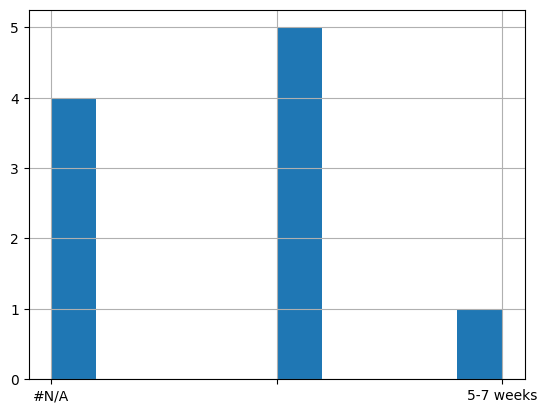

In [14]:
assays.drop_duplicates('material')['measurement_group_name'].hist()

### Measurement groups
The biological systems where the toxicity events were observed.

In [15]:
measurement_groups.describe()

,id,type,age,IRI
count,3,3,3,3
unique,3,3,2,3
top,G1,A549 cells,,http://purl.obolibrary.org/obo/BTO_0000018
freq,1,1,2,1


In [16]:
measurement_groups

,id,type,age,IRI
1,G1,A549 cells,,http://purl.obolibrary.org/obo/BTO_0000018
2,G2,HDF cells,,http://purl.obolibrary.org/obo/CL_0000057
3,G3,C57BL/6 mouse,5-7 weeks,http://purl.enanomapper.org/onto/placeholder_c...


### Nodes

The ontology terms used to annotate the relationships

In [17]:
node_breakdown.describe()

,node,curated,node_label,comments,predicate_to_material,used,need_term_request,IRI_enm_jvr,IRI
count,103,103,103,103,103,103,68,68,34
unique,103,2,103,9,1,2,1,38,34
top,N1,Yes,core composition,,,FALSE,,,http://purl.bioontology.org/ontology/npo#NPO_895
freq,1,68,1,95,103,69,68,28,1


In [18]:
node_breakdown.sample(5)

,node,curated,node_label,comments,predicate_to_material,used,need_term_request,IRI_enm_jvr,IRI
69,N71,No,doping (inorganic),,,FALSE,None,None,None
1,N1,Yes,core composition,,,FALSE,,http://purl.bioontology.org/ontology/npo#NPO_1808,None
24,N24,Yes,enzyme degredation,,,FALSE,,http://www.biopax.org/release/biopax-level3.ow...,None
53,N54,Yes,apoptosis-associated speck-like protein contai...,,,FALSE,,https://www.ensembl.org/id/ENSG00000103490,None
94,N99,Yes,band gap,,,TRUE,,,http://semanticscience.org/resource/CHEMINF_00...


## Retrieve licenses

This step retrieves the licenses for the journal articles from unpaywall.

In [19]:
def check_open_access(doi):
    id = doi.split('.org/')[1]
    api_url = 'https://api.unpaywall.org/v2/{}?email={}'.format(id,EMAIL)
    try:
        response = requests.get(api_url).json()
        if response['is_oa'] == True:
            try:
                license = response['best_oa_location']['license']
            except:
                license = 'NA/closed'
            return True, license
        else:
            return False, 'closed'
    except Exception as e:
        print('Exception for: {}. Could not retrieve {})'.format(api_url, e))
        return 'NA'

for doi in set(assertions['doi']):
    if isinstance(doi, str) and 'https' in doi:
        is_oa = check_open_access(doi)
        if isinstance(is_oa[0], bool):
            assertions.loc[assertions['doi'] == doi, 'is_oa'] = is_oa[0]
            assertions.loc[assertions['doi'] == doi, 'license'] = is_oa[1]


/tmp/ipykernel_331867/2756450508.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  assertions.loc[assertions['doi'] == doi, 'is_oa'] = is_oa[0]
/tmp/ipykernel_331867/2756450508.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'closed' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  assertions.loc[assertions['doi'] == doi, 'license'] = is_oa[1]


Plotting the different license types, we see a majority of non-open papers:

<AxesSubplot: >

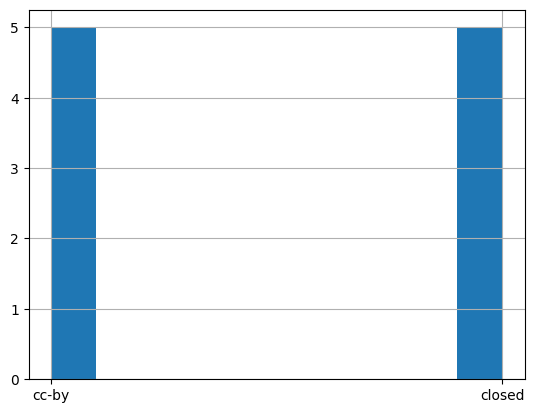

In [20]:
assertions.drop_duplicates('doi')['license'].hist()

/tmp/ipykernel_331867/3258799233.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  quotes.loc[quotes['doi'] == doi, 'is_oa'] = is_oa[0]
/tmp/ipykernel_331867/3258799233.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'closed' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  quotes.loc[quotes['doi'] == doi, 'license'] = is_oa[1]


<AxesSubplot: >

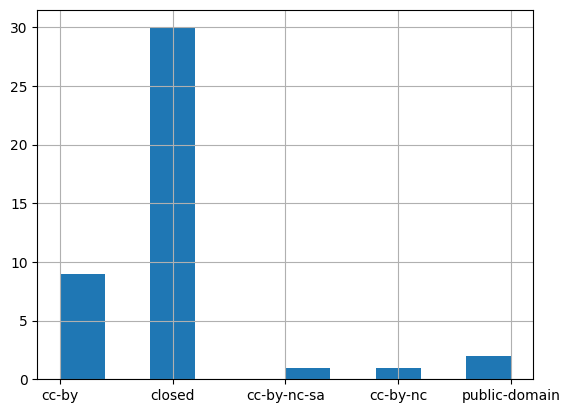

In [21]:
for doi in set(quotes['doi']):
    if isinstance(doi, str) and 'https' in doi:
        is_oa = check_open_access(doi)
        if isinstance(is_oa[0], bool):
            quotes.loc[quotes['doi'] == doi, 'is_oa'] = is_oa[0]
            quotes.loc[quotes['doi'] == doi, 'license'] = is_oa[1]
quotes.drop_duplicates('doi')['license'].hist()

## Define RDF namespaces




In [22]:
# TODO define sbdbel properly (ontological modelling of stated correlations? stated effects? need to discuss)

In [23]:
sbd = Namespace('https://www.sbd4nano.eu/rdf/#')
sbdbel = Namespace('https://www.sbd4nano.eu/bel/#')
ECO = Namespace('https://evidenceontology.org/#')
kb = Namespace('https://h2020-sbd4nano.github.io/sbd-data-landscape/')
enm = Namespace('http://purl.enanomapper.org/onto/')
ncit = Namespace('http://purl.obolibrary.org/obo/NCIT')
npo = Namespace('http://purl.bioontology.org/ontology/npo#')
pato = Namespace('http://purl.org/obo/owl/PATO#')
cito = Namespace('http://purl.org/spar/cito/')
gracious = Namespace('https://h2020-sbd4nano.github.io/sbd4nano-gracious-owl/gracious.html#')
aop_event = Namespace('https://identifiers.org/aop.events/')
bio = Namespace('http://purl.jp/bio/4/id/')
sio = Namespace('http://semanticscience.org/resource/')
efo = Namespace('http://www.ebi.ac.uk/efo/')
penm = Namespace('http://purl.placeholder.enanomapper.net/')

## RDFy
The following section creates the first iteration for the SbD4Nano graph for the TiO2:SiO2 material. Please note that this is work in progress and some properties and classes are only placeholders. Future iterations will describe the rest of data annotated in the spreadsheets in a well-defined schema.


In [24]:
g = Graph()
g.bind('dc', DC)
g.bind('rdfs', RDFS)
g.bind('foaf', FOAF)
g.bind('dcterms', DCTERMS)
g.bind('dc', DC)
g.bind('void', VOID)
g.bind('rdf', RDF)
g.bind('xsd', XSD)
g.bind('eco', ECO)
g.bind('sbd', sbd)
g.bind('sbdbel', sbdbel)
g.bind('kb', kb)
g.bind('enm', enm)
g.bind('ncit', ncit)
g.bind('npo', npo)
g.bind('pato', pato)
g.bind('cito', cito)
g.bind('gracious', gracious)
g.bind('aop_event', aop_event)
g.bind('bio', bio)
g.bind('sio', sio)
g.bind('void', VOID)
g.bind('efo', efo)
g.bind('placeholder', penm)
source = URIRef(f'https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}')
void_source = URIRef("https://github.com/h2020-sbd4nano/relationship_network")
g.add((void_source, RDF.type, VOID.DatasetDescription))
g.add((void_source, FOAF.page, URIRef("https://www.sbd4nano.eu/")))
g.add((void_source, DC.source, source))
g.add((void_source, DC.title, Literal("SbD4nano WP2 TiO2:SiO2 Relationships", lang="en")))

for i, row in assertions.iterrows():
    # For each assertion row, find all supporting collected data
    quote_id = row['Ref_quote']
    relation_id = f'tio2sio2_{i}' # TODO agree on ids for observed relations
    relation = URIRef(f"https://h2020-sbd4nano.github.io/sbd-data-landscape/CausalAssertion_{relation_id}")

    # cause (# TODO: rename to subject)
    cause = BNode()
    cause_node = node_breakdown[node_breakdown['node'] == row['s']].index.tolist()
    # TODO check modelling of asserted 'causes' (not causes if these are 'correlations' or rather 'assertions/observations')
    # TODO (continue) Types of causes
    ## Exposure

    ## Intrinsic material property

    ## etc, same for outcome

    # TODO: approach for now to refer to the measurement group (use cell line class as predicate)
    if row['measurement group'] in list(measurement_groups['id']):
        measurement_group = row['measurement group']
        measurement_group_iri = measurement_groups.loc[measurement_groups['id'] == measurement_group, "IRI"].iloc[0]
        g.add((relation, enm.CL_00010304, URIRef(str(measurement_group_iri))))
    g.add((relation, URIRef(sbdbel + "cause"), cause))
    g.add((cause, RDFS.label, Literal(node_breakdown['node_label'][cause_node[0]])))
    g.add((cause, RDF.type, URIRef(str(node_breakdown.IRI[cause_node[0]]))))
    #g.add((cause, OWL.sameAs, URIRef(str(node_breakdown.Gracious[cause_node[0]]))))
    #g.add((cause, OWL.sameAs, URIRef(str(node_breakdown.AOPWiki[cause_node[0]]))))


    # outcome (# TODO: rename to object)
    outcome = BNode()
    outcome_node = node_breakdown[node_breakdown['node'] == row['o']].index.tolist()
    reference = row['doi']
    cites = row['citesAsReference']
    if cites != None:
        if ',' in cites:
            cites  = cites.split(",")
        else:
            cites = [cites]
    g.add((relation, URIRef(sbdbel + "outcome"), outcome))
    g.add((outcome, RDFS.label, Literal(node_breakdown['node_label'][outcome_node[0]])))
    #g.add((outcome, OWL.sameAs, URIRef(str(node_breakdown.IRI[outcome_node[0]]))))
    #g.add((outcome, OWL.sameAs, URIRef(str(node_breakdown.Gracious[outcome_node[0]]))))
    #g.add((outcome, OWL.sameAs, URIRef(str(node_breakdown.AOPWiki[outcome_node[0]]))))

    # material
    if row['material_id'] in list(materials['id']):
        material_id = row['material_id']
        material_label = row['material']
        material_iri = materials.loc[materials['id'] == material_id, "IRI"].iloc[0]
        g.add((relation, enm.CL_00010304, URIRef(str(measurement_group_iri))))
        material= BNode()
        g.add((material, RDF.type, Literal(str(material_label))))
        description = materials.loc[materials['id'] == material_id, "label"].iloc[0] #Just to have a description
        g.add((material, sio.description, Literal(description)))
        g.add((relation, URIRef(DCTERMS.subject), material))
        print(material_iri)
        g.add((material, OWL.sameAs, URIRef(material_iri)))

    # relation
    g.add((relation, RDF.type, URIRef(sbd + "resource")))
    g.add((relation, RDF.type, URIRef(sbd + "CausalAssertion")))
    g.add((relation, DC.source, source))
    
    # TODO change, For now: source is a literal
    g.add((relation, sio.SIO_000299, Literal(row['quote'])))
    if type(cites)==list:
        for cite in cites:
            g.add((relation, cito.cites, Literal(str(cite))))
    g.add((relation, URIRef(sbdbel + "relationship"), URIRef(sbdbel + row['p'])))
    g.add((relation,DC.source, URIRef(reference)))
    
g.serialize(format='turtle', destination='ttl/assertions.ttl')



http://purl.placeholder.enanomapper.net/1:1-nanocomposite-of-TiO2-in-a-Silica-coat
http://purl.placeholder.enanomapper.net/3:1-nanocomposite-of-TiO2-in-a-Silica-coat
http://purl.placeholder.enanomapper.net/3:1-nanocomposite-of-TiO2-in-a-Silica-coat
http://purl.placeholder.enanomapper.net/1:1-nanocomposite-of-TiO2-in-a-Silica-coat
http://purl.placeholder.enanomapper.net/1:1-nanocomposite-of-TiO2-in-a-Silica-coat
http://purl.placeholder.enanomapper.net/3:1-nanocomposite-of-TiO2-in-a-Silica-coat
http://purl.placeholder.enanomapper.net/3:1-nanocomposite-of-TiO2-in-a-Silica-coat
http://purl.placeholder.enanomapper.net/1:1-nanocomposite-of-TiO2-in-a-Silica-coat
http://purl.placeholder.enanomapper.net/3:1-nanocomposite-of-TiO2-in-a-Silica-coat
http://purl.placeholder.enanomapper.net/TiO2:SiO2
http://purl.placeholder.enanomapper.net/TiO2:SiO2
http://purl.placeholder.enanomapper.net/TiO2:SiO2
http://purl.placeholder.enanomapper.net/TiO2:SiO2
http://purl.placeholder.enanomapper.net/TiO2:SiO2
htt

<Graph identifier=N9b79558535fc4334874f14bbf7438cb8 (<class 'rdflib.graph.Graph'>)>

In [25]:
!cat ttl/assertions.ttl

@prefix cito: <http://purl.org/spar/cito/> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix enm: <http://purl.enanomapper.org/onto/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix kb: <https://h2020-sbd4nano.github.io/sbd-data-landscape/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix pato: <http://purl.org/obo/owl/PATO#> .
@prefix placeholder: <http://purl.placeholder.enanomapper.net/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sbd: <https://www.sbd4nano.eu/rdf/#> .
@prefix sbdbel: <https://www.sbd4nano.eu/bel/#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix void: <http://rdfs.org/ns/void#> .

<https://github.com/h2020-sbd4nano/relationship_network> a void:DatasetDescription ;
    dc:source <https://docs.google.com/spreadsheets/d/13dqwura-jSnGMVBSO7pVXfRgbPegGC7QNoSLNAFls3A> ;
    dc:title "SbD4nano WP2 TiO2:SiO2 Relationships"@en ;
    foaf:page <https://www.sbd4nano.e

## QC SPARQL Queries